In [1]:
from utils.dataloader import DataPartitions, DataGenerator
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
# sequences: array(
#   (x:Array, y:Dictionary)
# )
#
partitions = DataPartitions(
    past_frames=6,
    future_frames=1,
    root="../datasets/arda/04_21_full/",
    partial=0.5
)

In [3]:
dataset = DataGenerator(
    root="../datasets/arda/04_21_full/", 
    dataset_partitions=partitions.get_partitions(),
    past_frames=partitions.past_frames, 
    future_frames=partitions.future_frames,
    input_dim=(partitions.past_frames, 256, 256, 3),
    output_dim=(partitions.future_frames, 256, 256, 2),
    batch_size=4,
    n_channels=1,
    buffer_size=1e3,
    buffer_memory=100,
    downsampling=False,
)

In [4]:
X = dataset.get_X()
Y = dataset.get_Y()

X[X > 10e5] = 0 
Y[Y > 10e5] = 0

100%|██████████| 108/108 [01:23<00:00,  1.29it/s]


0.7553338104193836


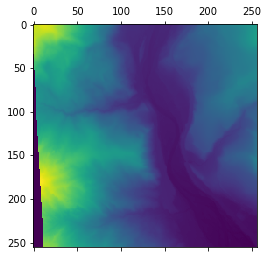

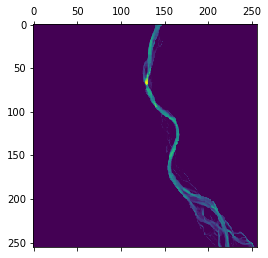

In [5]:
print(dataset.buffer_hit_ratio)

i = 3
j = 5

plt.matshow(X[j, i, 0, :, :, 2])

plt.matshow(X[j, i, 0, :, :, 0])
#plt.matshow(X[j, i, 2, :, :, 0])
#plt.matshow(X[j, i, 4, :, :, 0])
#plt.matshow(Y[j, i, 0, :, :, 0])

In [6]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

X, Y = unison_shuffled_copies(X, Y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
print("DEP min: {}\nVEL min: {}\nBTM min: {}".format(
    np.min(X_train[:, :, :, :, :, 0]),
    np.min(X_train[:, :, :, :, :, 1]),
    np.min(X_train[:, :, :, :, :, 2])
))

print("DEP max: {}\nVEL max: {}\nBTM max: {}".format(
    np.max(X_train[:, :, :, :, :, 0]),
    np.max(X_train[:, :, :, :, :, 1]),
    np.max(X_train[:, :, :, :, :, 2])
))

DEP min: 0.0
VEL min: 0.0
BTM min: 0.0
DEP max: 4.06716
VEL max: 6.747520127609847
BTM max: 166.27399999999997


### Model

In [9]:
import numpy as np

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

In [10]:
if th.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = th.device(dev) 

In [11]:
class ResNetBlock(nn.Module):
        
    def __init__(self, in_filters, filters, stride, kernel_size, padding):
        super(ResNetBlock, self).__init__()
        
        self.activation = nn.ReLU()
        self.c1 = nn.Conv3d(in_filters, filters, kernel_size, stride, padding=padding)
        self.c2 = nn.Conv3d(filters, filters, kernel_size, padding=padding)
        self.c3 = nn.Conv3d(in_filters, filters, (1, 1, 1), stride)
        
        #self.bn = nn.BatchNorm3d(num_features=filters)

    def forward(self, x,):
        
        residual = x
        
        y = self.c1(x)

        #y = self.bn(y)
        y = self.activation(y)
        y = self.c2(y)
        #y = self.bn(y)

        # reshape
        if residual.shape != y.shape:
            residual = self.c3(residual)
            #residual = self.bn(residual)
            
        return self.activation(residual + y)


In [12]:
class Autoencoder(nn.Module):
    
    def __init__(self, channels):
        super(Autoencoder, self).__init__()

        kernel_size = 3
        padding = 1

        self.layers = nn.ModuleList([
            nn.Conv3d(channels, 8, kernel_size=kernel_size, stride=1, padding=padding),
            nn.AvgPool3d((1,2,2)),
            
            ResNetBlock(in_filters = 8, filters = 8, stride = 2, kernel_size=kernel_size, padding=padding),

            nn.Conv3d(8, 16, (1,1,1)),
            ResNetBlock(in_filters = 16, filters = 16, stride = 2, kernel_size=kernel_size, padding=padding),

            nn.Conv3d(16, 32, (1,1,1)),
            ResNetBlock(in_filters = 32, filters = 32, stride = (2,1,1), kernel_size=kernel_size, padding=padding),

            nn.Conv3d(32, 64, (1,1,1)),
            ResNetBlock(in_filters = 64, filters = 64, stride = 1, kernel_size=kernel_size, padding=padding),

            # ----------------------

            nn.ConvTranspose3d(64, 32, (1,2,2), stride=(1,2,2)),
            #nn.BatchNorm3d(num_features=32),

            nn.ConvTranspose3d(32, 16, (1,2,2), stride=(1,2,2)),
            #nn.BatchNorm3d(num_features=16),

            nn.ConvTranspose3d(16, 8, (1,2,2), stride=(1,2,2)),
            #nn.BatchNorm3d(num_features=8),

            nn.ConvTranspose3d(8, 8, (1,1,1), stride=(1,1,1)),
            #nn.BatchNorm3d(num_features=8),
            
            nn.ConvTranspose3d(8, 2, (1,1,1), stride=(1,1,1)),
        ])
    
    def forward(self, x, summary = False):
        
        if summary:
            print("==== Model Summary ====")
            print("{:<15s}{:>4s}".format("Block", "Output shape"))

        for i, l in enumerate(self.layers):
            x = l(x)
            
            if summary:
                print("{:<20s}{:>4s}".format(
                    str(l).split("(")[0],
                    str(x.shape).split("[")[1].split("]")[0]
                ))
        
        return x

In [13]:
def xavier_weights(m):
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        th.nn.init.xavier_uniform(m.weight.data)

def sqrt_weights(m):
    # https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
    if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

In [14]:
net = Autoencoder(channels=3).to(device)
net(th.Tensor(np.random.random((16, 3, 6, 128, 128))).to(device), True).shape

==== Model Summary ====
Block          Output shape
Conv3d              16, 8, 6, 128, 128
AvgPool3d           16, 8, 6, 64, 64
ResNetBlock         16, 8, 3, 32, 32
Conv3d              16, 16, 3, 32, 32
ResNetBlock         16, 16, 2, 16, 16
Conv3d              16, 32, 2, 16, 16
ResNetBlock         16, 32, 1, 16, 16
Conv3d              16, 64, 1, 16, 16
ResNetBlock         16, 64, 1, 16, 16
ConvTranspose3d     16, 32, 1, 32, 32
ConvTranspose3d     16, 16, 1, 64, 64
ConvTranspose3d     16, 8, 1, 128, 128
ConvTranspose3d     16, 8, 1, 128, 128
ConvTranspose3d     16, 2, 1, 128, 128


torch.Size([16, 2, 1, 128, 128])

In [15]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [16]:
X_train = th.Tensor(X_train).to(device)
y_train = th.Tensor(y_train).to(device)

In [17]:
X_train = X_train.permute(0, 1, 5, 2, 3, 4)
y_train = y_train.permute(0, 1, 5, 2, 3, 4)

In [18]:
X_test = th.Tensor(X_test).to(device)
y_test = th.Tensor(y_test).to(device)

In [19]:
X_test = X_test.permute(0, 1, 5, 2, 3, 4)
y_test = y_test.permute(0, 1, 5, 2, 3, 4)

In [20]:
import pytorch_ssim
from torch.autograd import Variable

def reverse_ssim(y, y_true):

    tot_ssim = 0
    for i, y_pred in enumerate(y):
        y_h_pred = Variable(y_pred)
        y_h_true = Variable(y_true[0][i])

        if th.cuda.is_available():
            y_h_pred = y_h_pred.cuda()
            y_h_true = y_h_true.cuda()

        tot_ssim += pytorch_ssim.ssim(y_h_pred, y_h_true)

    return 1/(tot_ssim/len(y))

In [21]:
losses = []
errors = []
test_errors = []

/home/diego/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:2648: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629395347/work/aten/src/ATen/native/TensorIterator.cpp:918.)
  ret = torch._C._nn.mse_loss(expanded_input, expanded_target, _Reduction.get_enum(reduction))


[0,     8] train_err: 16.929 	  test_err: 17.803 	 avg_loss: 0.300


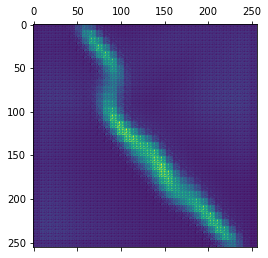

[1,     5] train_err: 7.335 	  test_err: 7.120 	 avg_loss: 0.199
[2,     7] train_err: 3.104 	  test_err: 2.718 	 avg_loss: 0.154
[3,    12] train_err: 2.257 	  test_err: 2.176 	 avg_loss: 0.127


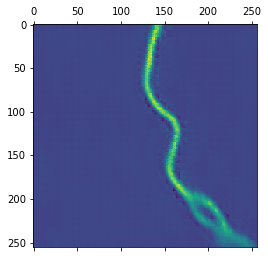

[4,    15] train_err: 2.661 	  test_err: 2.453 	 avg_loss: 0.110
[5,    19] train_err: 2.294 	  test_err: 2.200 	 avg_loss: 0.098
[6,    18] train_err: 1.928 	  test_err: 1.870 	 avg_loss: 0.088


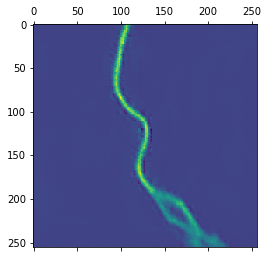

[7,    19] train_err: 1.758 	  test_err: 1.812 	 avg_loss: 0.081
[8,    18] train_err: 1.578 	  test_err: 1.552 	 avg_loss: 0.076
[9,     8] train_err: 1.623 	  test_err: 1.658 	 avg_loss: 0.071


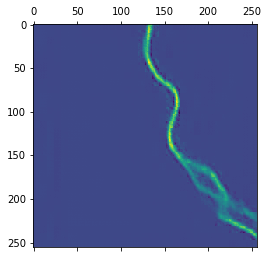

[10,     0] train_err: 1.490 	  test_err: 1.479 	 avg_loss: 0.067
[11,     1] train_err: 1.541 	  test_err: 1.503 	 avg_loss: 0.064
[12,     5] train_err: 1.346 	  test_err: 1.336 	 avg_loss: 0.061


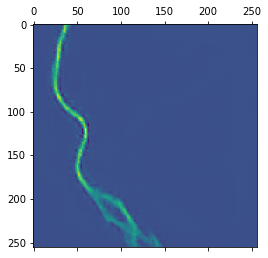

[13,     3] train_err: 1.606 	  test_err: 1.561 	 avg_loss: 0.059
[14,     9] train_err: 1.172 	  test_err: 1.162 	 avg_loss: 0.056
[15,    16] train_err: 1.436 	  test_err: 1.433 	 avg_loss: 0.054


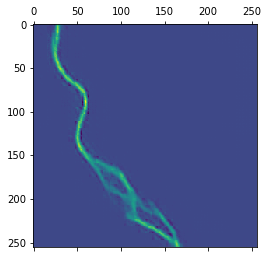

[16,     7] train_err: 1.505 	  test_err: 1.493 	 avg_loss: 0.053
[17,     9] train_err: 1.158 	  test_err: 1.148 	 avg_loss: 0.051
[18,     7] train_err: 1.437 	  test_err: 1.437 	 avg_loss: 0.049


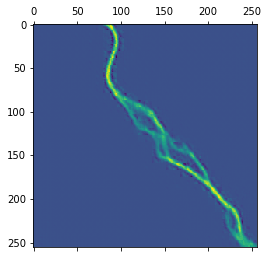

[19,     2] train_err: 1.431 	  test_err: 1.424 	 avg_loss: 0.048
[20,    18] train_err: 1.407 	  test_err: 1.413 	 avg_loss: 0.047
[21,    14] train_err: 1.160 	  test_err: 1.178 	 avg_loss: 0.046


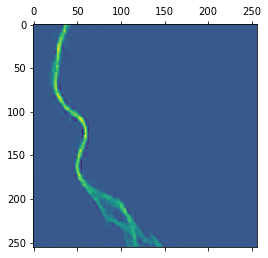

[22,     1] train_err: 1.409 	  test_err: 1.393 	 avg_loss: 0.044
[23,    13] train_err: 1.353 	  test_err: 1.366 	 avg_loss: 0.043
[24,     3] train_err: 1.396 	  test_err: 1.394 	 avg_loss: 0.042


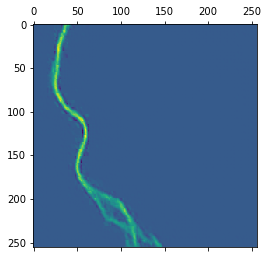

[25,     3] train_err: 1.403 	  test_err: 1.398 	 avg_loss: 0.042
[26,     8] train_err: 1.457 	  test_err: 1.458 	 avg_loss: 0.041
[27,    12] train_err: 1.460 	  test_err: 1.454 	 avg_loss: 0.040


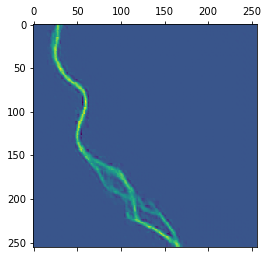

[28,    21] train_err: 1.470 	  test_err: 1.473 	 avg_loss: 0.039
[29,    15] train_err: 1.376 	  test_err: 1.377 	 avg_loss: 0.038
[30,    15] train_err: 1.382 	  test_err: 1.387 	 avg_loss: 0.038


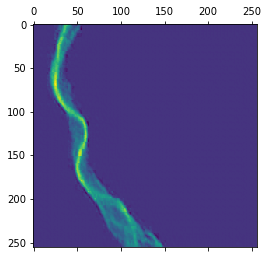

[31,    21] train_err: 1.471 	  test_err: 1.460 	 avg_loss: 0.037
[32,    13] train_err: 1.366 	  test_err: 1.381 	 avg_loss: 0.037
[33,     1] train_err: 1.444 	  test_err: 1.433 	 avg_loss: 0.036


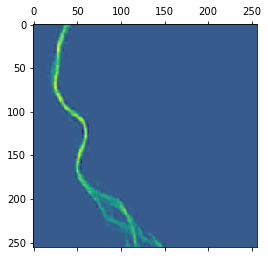

[34,    20] train_err: 1.338 	  test_err: 1.334 	 avg_loss: 0.035
[35,     0] train_err: 1.430 	  test_err: 1.410 	 avg_loss: 0.035
[36,    11] train_err: 1.319 	  test_err: 1.335 	 avg_loss: 0.034


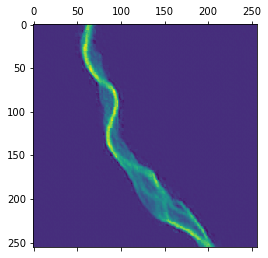

[37,     7] train_err: 1.515 	  test_err: 1.517 	 avg_loss: 0.034
[38,     8] train_err: 1.481 	  test_err: 1.493 	 avg_loss: 0.033
[39,     5] train_err: 1.319 	  test_err: 1.318 	 avg_loss: 0.033


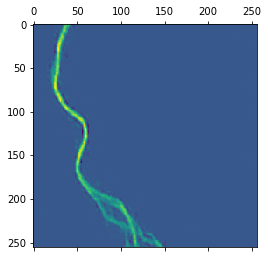

[40,    14] train_err: 1.186 	  test_err: 1.210 	 avg_loss: 0.033
[41,     4] train_err: 1.183 	  test_err: 1.178 	 avg_loss: 0.032
[42,    12] train_err: 1.564 	  test_err: 1.547 	 avg_loss: 0.032


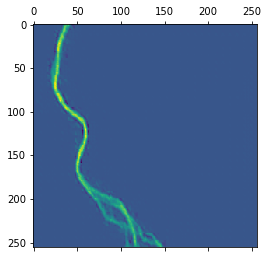

[43,     1] train_err: 1.571 	  test_err: 1.532 	 avg_loss: 0.031
[44,     1] train_err: 1.547 	  test_err: 1.519 	 avg_loss: 0.031
[45,     4] train_err: 1.158 	  test_err: 1.152 	 avg_loss: 0.031


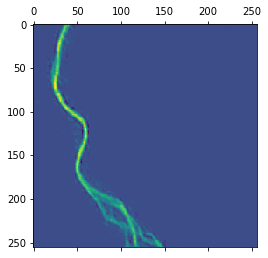

[46,    21] train_err: 1.529 	  test_err: 1.523 	 avg_loss: 0.030
[47,     8] train_err: 1.478 	  test_err: 1.488 	 avg_loss: 0.030
[48,    16] train_err: 1.436 	  test_err: 1.427 	 avg_loss: 0.030


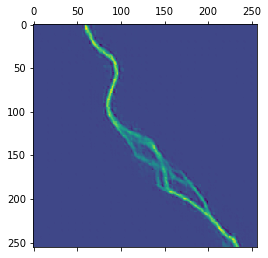

[49,     3] train_err: 1.428 	  test_err: 1.415 	 avg_loss: 0.029
[50,    10] train_err: 1.434 	  test_err: 1.440 	 avg_loss: 0.029
[51,     0] train_err: 1.457 	  test_err: 1.445 	 avg_loss: 0.029


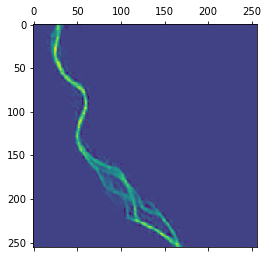

[52,    16] train_err: 1.500 	  test_err: 1.489 	 avg_loss: 0.029
[53,     8] train_err: 1.559 	  test_err: 1.564 	 avg_loss: 0.028
[54,    15] train_err: 1.584 	  test_err: 1.580 	 avg_loss: 0.028


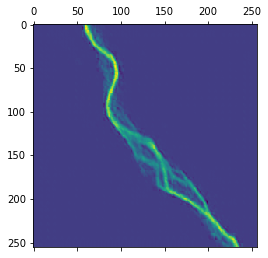

[55,     6] train_err: 1.487 	  test_err: 1.469 	 avg_loss: 0.028
[56,    15] train_err: 1.422 	  test_err: 1.435 	 avg_loss: 0.028
[57,    11] train_err: 1.311 	  test_err: 1.323 	 avg_loss: 0.027


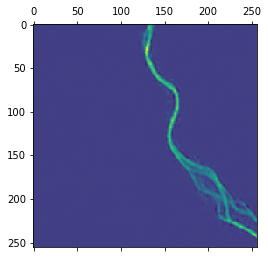

[58,     4] train_err: 1.148 	  test_err: 1.141 	 avg_loss: 0.027
[59,    12] train_err: 1.536 	  test_err: 1.532 	 avg_loss: 0.027
[60,     1] train_err: 1.417 	  test_err: 1.403 	 avg_loss: 0.027


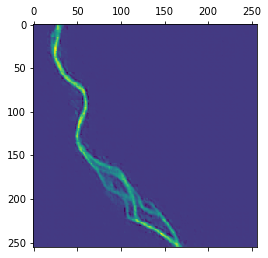

[61,     2] train_err: 1.453 	  test_err: 1.451 	 avg_loss: 0.026
[62,    20] train_err: 1.345 	  test_err: 1.338 	 avg_loss: 0.026
[63,    21] train_err: 1.459 	  test_err: 1.447 	 avg_loss: 0.026


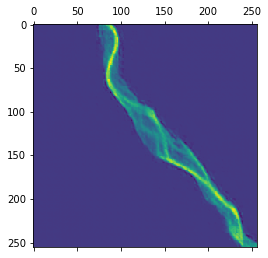

[64,     7] train_err: 1.435 	  test_err: 1.451 	 avg_loss: 0.026
[65,    17] train_err: 1.340 	  test_err: 1.338 	 avg_loss: 0.026
[66,     2] train_err: 1.448 	  test_err: 1.448 	 avg_loss: 0.025


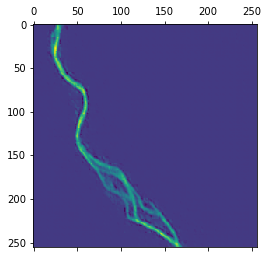

[67,    16] train_err: 1.459 	  test_err: 1.454 	 avg_loss: 0.025
[68,    14] train_err: 1.210 	  test_err: 1.227 	 avg_loss: 0.025
[69,    17] train_err: 1.506 	  test_err: 1.510 	 avg_loss: 0.025


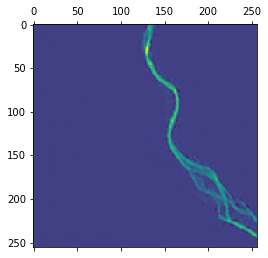

[70,     6] train_err: 1.462 	  test_err: 1.451 	 avg_loss: 0.025
[71,     6] train_err: 1.373 	  test_err: 1.364 	 avg_loss: 0.024
[72,    12] train_err: 1.459 	  test_err: 1.453 	 avg_loss: 0.024


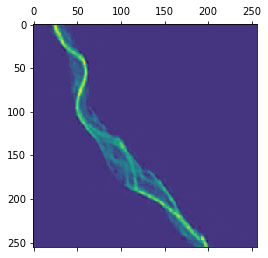

[73,     3] train_err: 1.417 	  test_err: 1.403 	 avg_loss: 0.024
[74,    20] train_err: 1.322 	  test_err: 1.313 	 avg_loss: 0.024
[75,    15] train_err: 1.352 	  test_err: 1.352 	 avg_loss: 0.024


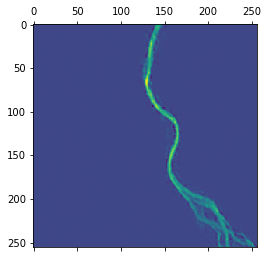

[76,    12] train_err: 1.459 	  test_err: 1.455 	 avg_loss: 0.024
[77,     8] train_err: 1.421 	  test_err: 1.433 	 avg_loss: 0.023
[78,    17] train_err: 1.318 	  test_err: 1.322 	 avg_loss: 0.023


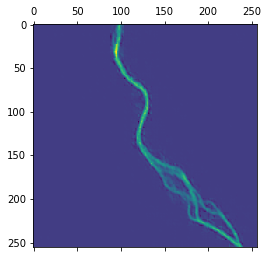

[79,    13] train_err: 1.354 	  test_err: 1.358 	 avg_loss: 0.023
[80,    11] train_err: 1.290 	  test_err: 1.287 	 avg_loss: 0.023
[81,     2] train_err: 1.486 	  test_err: 1.474 	 avg_loss: 0.023


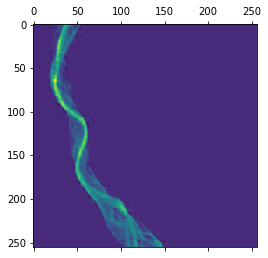

[82,    15] train_err: 1.400 	  test_err: 1.409 	 avg_loss: 0.023
[83,     5] train_err: 1.337 	  test_err: 1.339 	 avg_loss: 0.023
[84,     0] train_err: 1.458 	  test_err: 1.445 	 avg_loss: 0.023


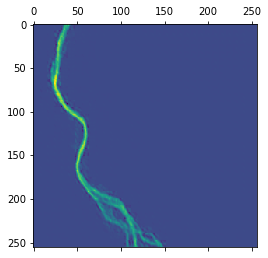

[85,     0] train_err: 1.430 	  test_err: 1.416 	 avg_loss: 0.022
[86,    15] train_err: 1.364 	  test_err: 1.367 	 avg_loss: 0.022
[87,     1] train_err: 1.392 	  test_err: 1.389 	 avg_loss: 0.022


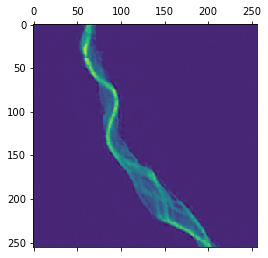

[88,     7] train_err: 1.424 	  test_err: 1.434 	 avg_loss: 0.022
[89,    19] train_err: 1.380 	  test_err: 1.371 	 avg_loss: 0.022
[90,     2] train_err: 1.412 	  test_err: 1.418 	 avg_loss: 0.022


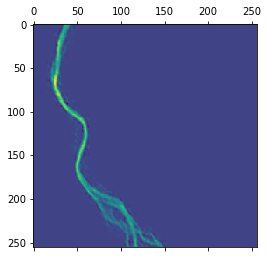

[91,    15] train_err: 1.344 	  test_err: 1.345 	 avg_loss: 0.022
[92,    14] train_err: 1.126 	  test_err: 1.152 	 avg_loss: 0.022
[93,     9] train_err: 1.117 	  test_err: 1.109 	 avg_loss: 0.021


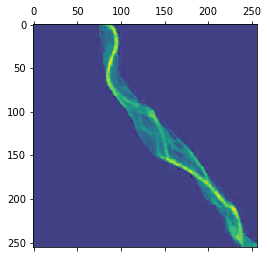

[94,    10] train_err: 1.328 	  test_err: 1.336 	 avg_loss: 0.021
[95,    11] train_err: 1.284 	  test_err: 1.280 	 avg_loss: 0.021
[96,     2] train_err: 1.401 	  test_err: 1.404 	 avg_loss: 0.021


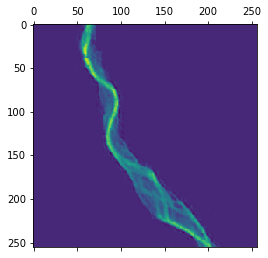

[97,     5] train_err: 1.276 	  test_err: 1.274 	 avg_loss: 0.021
[98,     9] train_err: 1.120 	  test_err: 1.113 	 avg_loss: 0.021
[99,     7] train_err: 1.389 	  test_err: 1.397 	 avg_loss: 0.021


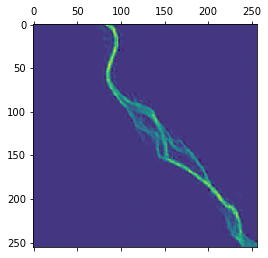

Finished Training


In [22]:
epochs = 100

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, batch in enumerate(X_train):

        optimizer.zero_grad()

        outputs = net(batch)
        
        loss = criterion(outputs, y_train[i])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        losses.append(loss.item())

        # print("batch {} - loss {}".format(i, loss.item()))

        if i == len(X_train)-1:
            # randomly pick a test batch and compute it
            i = np.random.randint(len(y_test), size=1)
            
            train_out = net(X_test[i][0])
            test_out = net(X_train[i][0])
            
            train_err = reverse_ssim(train_out, y_train[i]).item()
            test_err = reverse_ssim(test_out, y_test[i]).item()
        
            test_errors.append(test_err)
            errors.append(train_err)
            
            print('[%d, %5d] train_err: %.3f \t  test_err: %.3f \t avg_loss: %.3f' %
                  (epoch, i, train_err, test_err, np.mean(losses)))

    if epoch % 3 == 0:
        i = np.random.randint(len(X_test))
        outputs = net(X_test[i])
        for frame in outputs[0][0]:
            plt.matshow(frame.cpu().detach().numpy())
            plt.show()

        #if epoch % 10 == 0:
        #    print('[%d, %5d] loss: %.3f' %
        #          (epoch + 1, i + 1, running_loss / 2000))
        #    running_loss = 0.0

print('Finished Training')

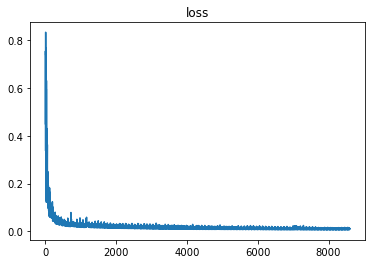

In [23]:
plt.title("loss")
plt.plot(range(len(losses)), losses)
pass

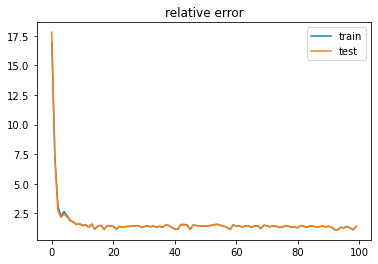

In [24]:
plt.title("relative error")
plt.plot(range(len(errors)), errors, label="train")
plt.plot(range(len(test_errors)), test_errors, label="test")
plt.legend()
pass


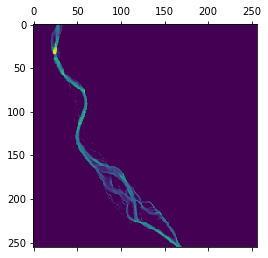

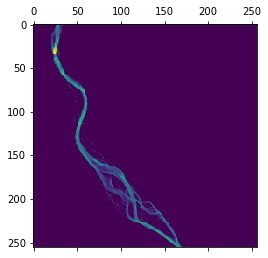

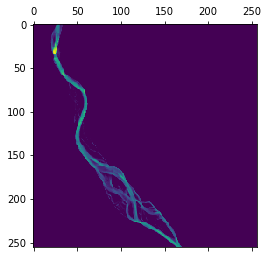

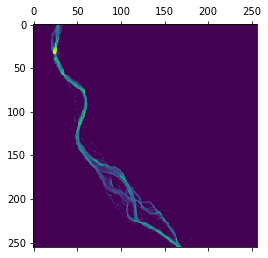

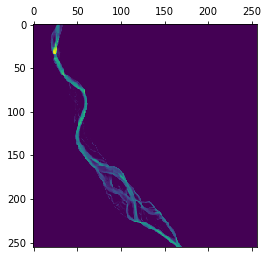

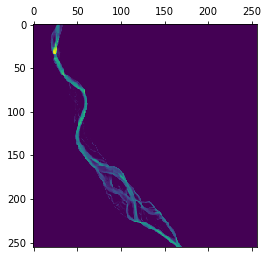

In [25]:
i = np.random.randint(len(X_test))
outputs = net(X_test[i])

for frame in X_test[i][0][0]:
    plt.matshow(frame.cpu().detach().numpy())

#for frame in y_test[i][0][0]:
#    plt.matshow(frame.cpu().detach().numpy())

torch.Size([4, 2, 1, 256, 256])


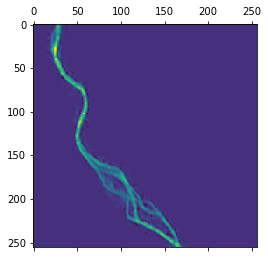

In [26]:
print(outputs.shape)
for frame in outputs[0][0]:
    plt.matshow(frame.cpu().detach().numpy())

0.041770793
0.042060398
0.04208811
0.04209144
0.04209196


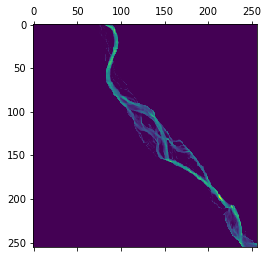

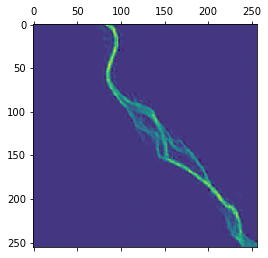

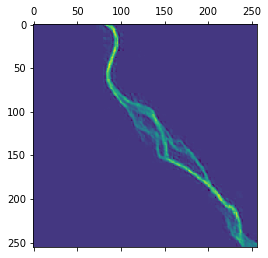

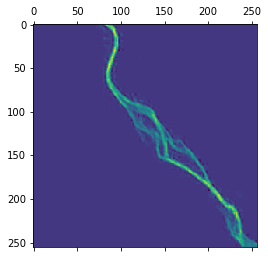

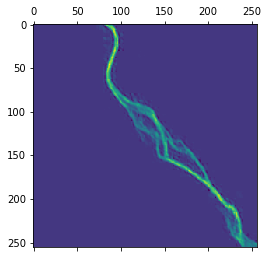

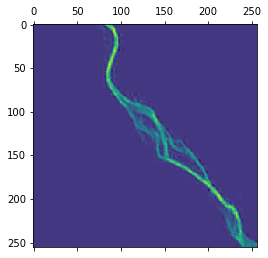

In [27]:
i = np.random.randint(len(X_test))
input = th.unsqueeze(X_test[i][0], 0)
plt.matshow(input[0,0,5,:,:].detach().cpu().numpy())

for x in range(5):
    output = net(input)
    next_frame = th.unsqueeze(output.detach()[0], 0)
    next_frame = th.cat((next_frame, th.unsqueeze(input[:,2:,0,:,:],2)), axis=1) # aggiungi BTM
    input = th.cat((next_frame, input[:,:,1:,:]), axis=2)

    for frame in output[0][0]:
        plt.matshow(frame.cpu().detach().numpy())
        print(np.mean(frame.cpu().detach().numpy()))

In [28]:
print("{:<20s}{:<20s}{:<20s}{:<20s}{:<20s}".format("", "min", "max", "mean", "std"))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("prediction", th.min(outputs), th.max(outputs), th.mean(outputs), th.std(outputs)))
print("{:<20s}{:<20f}{:<20f}{:<20f}{:<20f}".format("true", th.min(y_test[0]), th.max(y_test[0]), th.mean(y_test[0]), th.std(y_test[0])))

                    min                 max                 mean                std                 
prediction          -0.650183           4.570441            0.075320            0.376793            
true                0.000000            4.931404            0.059701            0.333728            
